In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
data = pd.read_csv('/content/drive/MyDrive/AI/trum_tweet_sentiment_analysis.csv')

In [15]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove stopwords and lemmatize
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return ' '.join(tokens)

In [16]:
data['cleaned_text'] = data['text'].apply(preprocess_text)

In [17]:
print(data[['text', 'cleaned_text']].head())

                                                text  \
0  RT @JohnLeguizamo: #trump not draining swamp b...   
1  ICYMI: Hackers Rig FM Radio Stations To Play A...   
2  Trump protests: LGBTQ rally in New York https:...   
3  "Hi I'm Piers Morgan. David Beckham is awful b...   
4  RT @GlennFranco68: Tech Firm Suing BuzzFeed fo...   

                                        cleaned_text  
0  rt trump draining swamp taxpayer dollar trip a...  
1  icymi hacker rig fm radio station play antitru...  
2    trump protest lgbtq rally new york bbcworld via  
3  hi im pier morgan david beckham awful donald t...  
4  rt tech firm suing buzzfeed publishing unverif...  


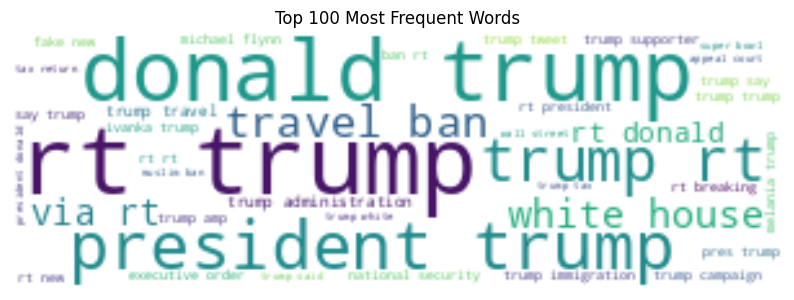

In [18]:
# --- Visualization: Word Cloud (Top 100 Words) ---
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_words = ' '.join(data['cleaned_text'])
# Generate WordCloud with only top 100 words
wordcloud = WordCloud(
  width=300,
  height=100,
  background_color='white',
  max_words=100 # Limit to top 100 words
).generate(all_words)
# Plot settings
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 100 Most Frequent Words')
plt.show()

In [19]:
from sklearn.model_selection import train_test_split

# Split FIRST (before tokenization/vectorization)
X_train, X_test, y_train, y_test = train_test_split(
    data['cleaned_text'],        # Features (text)
    data['Sentiment'],   # Labels (numerical sentiment)
    test_size=0.2,
    random_state=42
)

In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Sample Twitter reviews
texts = [
    "I love this product!",
    "Worst purchase ever.",
    "Happy with the experience.",
    "Not great, not terrible.",
    "Absolutely fantastic!"
]

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")  # 'num_words' limits vocab size; 'oov_token' handles unknown words
tokenizer.fit_on_texts(texts)  # Learn word index from the training texts

# Convert text to sequences of integers
sequences = tokenizer.texts_to_sequences(texts)

# Print results
print("Word Index:", tokenizer.word_index)
print("Sequences:", sequences)

Word Index: {'<OOV>': 1, 'not': 2, 'i': 3, 'love': 4, 'this': 5, 'product': 6, 'worst': 7, 'purchase': 8, 'ever': 9, 'happy': 10, 'with': 11, 'the': 12, 'experience': 13, 'great': 14, 'terrible': 15, 'absolutely': 16, 'fantastic': 17}
Sequences: [[3, 4, 5, 6], [7, 8, 9], [10, 11, 12, 13], [2, 14, 2, 15], [16, 17]]


In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train) # Vocabulary based ONLY on training data

In [22]:
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train) # Vocabulary based ONLY on training data
# Use the same tokenizer to transform both sets
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [64]:
max_len = max(len(seq) for seq in X_train_seq) # Longest sequence in training data

In [24]:
import numpy as np
seq_lengths = [len(seq) for seq in X_train_seq]
max_len = int(np.percentile(seq_lengths, 95)) # Covers 95% of sentences

In [25]:
# Calculate max_len using the 95th percentile
seq_lengths = [len(seq) for seq in X_train_seq]
max_len = int(np.percentile(seq_lengths, 95))  # You can tweak the percentile if needed

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

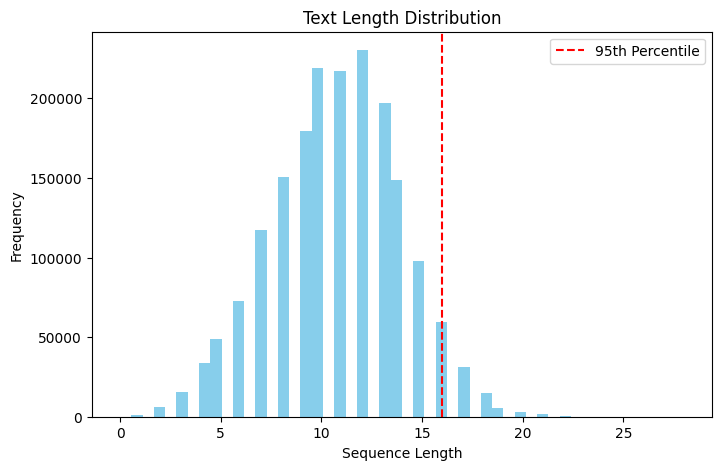

In [26]:
#Why 95 percentile
# Convert text to sequences
X_seq = tokenizer.texts_to_sequences(data['cleaned_text'])

# Calculate sequence lengths
seq_lengths = [len(seq) for seq in X_seq]

# Plot histogram of sequence lengths
plt.figure(figsize=(8, 5))
plt.hist(seq_lengths, bins=50, color='skyblue')
plt.title('Text Length Distribution')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axvline(np.percentile(seq_lengths, 95), color='red', linestyle='dashed', label='95th Percentile')
plt.legend()
plt.show()

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding

# Initialize the model
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=50))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [56]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

# Example parameters
vocab_size = 10000         # Size of vocabulary
embedding_dim = 128        # Dimension of embedding vectors
max_length = 100           # Maximum length of input sequences
rnn_units = 64             # Number of RNN units

# Build the model
model = Sequential([
    # Embedding layer converts word indices to dense vectors
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=max_length),

    # RNN layer processes the sequence
    SimpleRNN(units=rnn_units, return_sequences=False),

    # Final dense layer for binary classification
    Dense(1, activation='sigmoid')
])
model.build(input_shape=(None, max_length))
# Print model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,292,417 (4.93 MB)

 Trainable params: 1,292,417 (4.93 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [58]:
import numpy as np
from gensim.models import KeyedVectors
import gensim.downloader as api
from tensorflow.keras.preprocessing.text import Tokenizer

# Download and load the pre-trained Word2Vec model
# using 'word2vec-google-news-300'
word2vec_model = api.load("word2vec-google-news-300")

# Initialize the embedding matrix with zeros (vocab_size, embedding_dim)
vocab_size = len(tokenizer.word_index) + 1  # Add 1 for padding
embedding_dim = 300  # Word2Vec uses 300-dimensional vectors
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Map each word in the tokenizer’s word index to its Word2Vec vector
for word, index in tokenizer.word_index.items():
    if word in word2vec_model:
        embedding_matrix[index] = word2vec_model[word]

In [59]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

model = Sequential()

# Use the pre-trained Word2Vec embeddings in the Embedding Layer
model.add(Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],  # Load the pre-trained Word2Vec embeddings
    input_length=50,
    trainable=False  # Set to True if you want to fine-tune the embeddings
))

# Add an LSTM layer
model.add(LSTM(64))

# Output layer for sentiment classification (3 classes)
model.add(Dense(3, activation='softmax'))

In [60]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense
# RNN model
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=10000, output_dim=128, input_length=50))
rnn_model.add(SimpleRNN(64)) # Vanilla RNN layer
rnn_model.add(Dense(3, activation='softmax')) # For 3 sentiment classes
rnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
rnn_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [61]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
# LSTM model
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=10000, output_dim=128, input_shape=(16,)))
lstm_model.add(LSTM(64))  # LSTM layer
lstm_model.add(Dense(3, activation='softmax'))  # Output layer for 3-class classification
# Compile the model
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Display model architecture
lstm_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 16, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,329,603 (5.07 MB)

 Trainable params: 1,329,603 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
print("X_train_final shape:", X_train_final.shape)


X_train_final shape: (1184078, 16)


In [63]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical

# Step 1: Split first (before one-hot encoding!)
X_train_final, X_val_pad, y_train_final, y_val = train_test_split(
    X_train_pad, y_train, test_size=0.2, random_state=42
)

# Step 2: Then one-hot encode
y_train_cat = to_categorical(y_train_final, num_classes=3)
y_val_cat = to_categorical(y_val, num_classes=3)

# Compile the model
model.compile(
    loss='categorical_crossentropy',  # Use 'sparse_categorical_crossentropy' if labels are integers
    optimizer='adam',
    metrics=['accuracy']
)
# Save the best model during training
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)
# Stop training early if validation loss doesn’t improve for 3 epochs
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)
# Train the model
history = model.fit(
    X_train_final, y_train_cat,
    epochs=10,
    batch_size=64,
    validation_data=(X_val_pad, y_val_cat),
    callbacks=[checkpoint, early_stop]
)

Epoch 1/10
18500/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8730 - loss: 0.2989
Epoch 1: val_accuracy improved from -inf to 0.94288, saving model to best_model.h5


18502/18502 ━━━━━━━━━━━━━━━━━━━━ 523s 28ms/step - accuracy: 0.8730 - loss: 0.2989 - val_accuracy: 0.9429 - val_loss: 0.1561
Epoch 2/10
18502/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9489 - loss: 0.1410
Epoch 2: val_accuracy improved from 0.94288 to 0.95493, saving model to best_model.h5


18502/18502 ━━━━━━━━━━━━━━━━━━━━ 567s 28ms/step - accuracy: 0.9489 - loss: 0.1410 - val_accuracy: 0.9549 - val_loss: 0.1277
Epoch 3/10
18500/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9603 - loss: 0.1130
Epoch 3: val_accuracy improved from 0.95493 to 0.95858, saving model to best_model.h5


18502/18502 ━━━━━━━━━━━━━━━━━━━━ 491s 27ms/step - accuracy: 0.9603 - loss: 0.1130 - val_accuracy: 0.9586 - val_loss: 0.1182
Epoch 4/10
18500/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9661 - loss: 0.0978
Epoch 4: val_accuracy improved from 0.95858 to 0.96165, saving model to best_model.h5


18502/18502 ━━━━━━━━━━━━━━━━━━━━ 528s 28ms/step - accuracy: 0.9661 - loss: 0.0978 - val_accuracy: 0.9617 - val_loss: 0.1121
Epoch 5/10
18499/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9695 - loss: 0.0887
Epoch 5: val_accuracy improved from 0.96165 to 0.96359, saving model to best_model.h5


18502/18502 ━━━━━━━━━━━━━━━━━━━━ 518s 28ms/step - accuracy: 0.9695 - loss: 0.0887 - val_accuracy: 0.9636 - val_loss: 0.1082
Epoch 6/10
18501/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9725 - loss: 0.0808
Epoch 6: val_accuracy improved from 0.96359 to 0.96375, saving model to best_model.h5


18502/18502 ━━━━━━━━━━━━━━━━━━━━ 563s 28ms/step - accuracy: 0.9725 - loss: 0.0808 - val_accuracy: 0.9637 - val_loss: 0.1087
Epoch 7/10
18500/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9748 - loss: 0.0744
Epoch 7: val_accuracy improved from 0.96375 to 0.96474, saving model to best_model.h5


18502/18502 ━━━━━━━━━━━━━━━━━━━━ 561s 28ms/step - accuracy: 0.9748 - loss: 0.0744 - val_accuracy: 0.9647 - val_loss: 0.1066
Epoch 8/10
18501/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9760 - loss: 0.0710
Epoch 8: val_accuracy improved from 0.96474 to 0.96528, saving model to best_model.h5


18502/18502 ━━━━━━━━━━━━━━━━━━━━ 581s 29ms/step - accuracy: 0.9760 - loss: 0.0710 - val_accuracy: 0.9653 - val_loss: 0.1105
Epoch 9/10
18501/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9775 - loss: 0.0670
Epoch 9: val_accuracy improved from 0.96528 to 0.96617, saving model to best_model.h5


18502/18502 ━━━━━━━━━━━━━━━━━━━━ 539s 29ms/step - accuracy: 0.9775 - loss: 0.0670 - val_accuracy: 0.9662 - val_loss: 0.1089
Epoch 10/10
18502/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9792 - loss: 0.0627
Epoch 10: val_accuracy improved from 0.96617 to 0.96668, saving model to best_model.h5


18502/18502 ━━━━━━━━━━━━━━━━━━━━ 550s 28ms/step - accuracy: 0.9792 - loss: 0.0627 - val_accuracy: 0.9667 - val_loss: 0.1059
Restoring model weights from the end of the best epoch: 10.


In [68]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder  # Import LabelEncoder

# Create and fit LabelEncoder (before using it)
label_encoder = LabelEncoder()
label_encoder.fit(y_train)  # Fit on training data or the entire target column
# Predictions on the validation set
y_pred = model.predict(X_val_pad)
y_pred_classes = np.argmax(y_pred, axis=1) # Convert probabilities to class labels
# Accuracy score
# Change 1: Use y_val (original labels) instead of y_val_cat (one-hot encoded)
accuracy = accuracy_score(y_val, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")
# Confusion Matrix
# Change 2: Use y_val (original labels) instead of y_val_cat (one-hot encoded)
cm = confusion_matrix(y_val, y_pred_classes)
print("Confusion Matrix:")
print(cm)
# Classification Report
cr = classification_report(y_val, y_pred_classes, target_names=label_encoder.classes_)
print("Classification Report:")
print(cr)

   1/9251 ━━━━━━━━━━━━━━━━━━━━ 5:44 37ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


9251/9251 ━━━━━━━━━━━━━━━━━━━━ 71s 8ms/step
Accuracy: 0.9667
Confusion Matrix:
[[194471   4894]
 [  4968  91687]]


TypeError: object of type 'numpy.int64' has no len()

In [69]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder  # Import LabelEncoder

# Create and fit LabelEncoder (before using it)
label_encoder = LabelEncoder()
label_encoder.fit(y_train)  # Fit on training data or the entire target column
# Predictions on the validation set
y_pred = model.predict(X_val_pad)
y_pred_classes = np.argmax(y_pred, axis=1) # Convert probabilities to class labels
# Accuracy score
# Change 1: Use y_val (original labels) instead of y_val_cat (one-hot encoded)
accuracy = accuracy_score(y_val, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")
# Confusion Matrix
# Change 2: Use y_val (original labels) instead of y_val_cat (one-hot encoded)
cm = confusion_matrix(y_val, y_pred_classes)
print("Confusion Matrix:")
print(cm)
# Classification Report
# Get the original class labels as strings
target_names = label_encoder.classes_.astype(str).tolist()  # Convert to string list

cr = classification_report(y_val, y_pred_classes, target_names=target_names)
print("Classification Report:")
print(cr)

   9/9251 ━━━━━━━━━━━━━━━━━━━━ 58s 6ms/step  

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


9251/9251 ━━━━━━━━━━━━━━━━━━━━ 71s 8ms/step
Accuracy: 0.9667
Confusion Matrix:
[[194471   4894]
 [  4968  91687]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    199365
           1       0.95      0.95      0.95     96655

    accuracy                           0.97    296020
   macro avg       0.96      0.96      0.96    296020
weighted avg       0.97      0.97      0.97    296020



In [71]:
cr = classification_report(y_val, y_pred_classes, target_names=label_encoder.classes_.astype(str).tolist())  # Convert to string list
print("Classification Report:")
print(cr)

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    199365
           1       0.95      0.95      0.95     96655

    accuracy                           0.97    296020
   macro avg       0.96      0.96      0.96    296020
weighted avg       0.97      0.97      0.97    296020



In [ ]:
!apt-get install -y xvfb # Install Xvfb
import os
# Start the Xvfb server with more specific parameters and using a dedicated command
!Xvfb :1 -screen 0 1024x768x24 &
# Export DISPLAY variable for subprocesses to inherit
os.environ['DISPLAY'] = ":1"  # Set DISPLAY to the new server
# Add a delay to allow Xvfb to fully start
import time
time.sleep(5)
import tkinter as tk
from tkinter import messagebox

# Function to predict sentiment based on user input
def predict_sentiment_gui():
    user_input = entry.get()  # Get the text input from the user
    if user_input.strip() == "":
        messagebox.showwarning("Input Error", "Please enter a tweet for prediction!")
        return
    # Predict sentiment using the trained model
    prediction = predict_sentiment(user_input)
    # Display the result in the label
    result_label.config(text=f"Predicted Sentiment: {prediction}")

# Create the main window
root = tk.Tk()
root.title("Twitter Sentiment Predictor")

# Label for instructions
instruction_label = tk.Label(root, text="Enter a tweet to predict its sentiment:", font=("Arial", 14))
instruction_label.pack(pady=10)

# Entry box for user to input a tweet
entry = tk.Entry(root, width=50, font=("Arial", 12))
entry.pack(pady=10)

# Predict button to trigger sentiment prediction
predict_button = tk.Button(root, text="Predict Sentiment", font=("Arial", 12), command=predict_sentiment_gui)
predict_button.pack(pady=10)

# Label to display the predicted sentiment
result_label = tk.Label(root, text="", font=("Arial", 14), fg="blue")
result_label.pack(pady=10)

# Run the Tkinter main loop
root.mainloop()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.14).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
